In [1]:
import numpy as np
import XNLdyn
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool

%matplotlib notebook

In [2]:
import warnings
warnings.filterwarnings('default')

In [9]:

## Set up the problem
PAR = XNLdyn.XNLpars()

N_local_fluences_to_calculate = 30
N_pulse_energies = 20
Nsteps_r = 100

pulse_energy_J = 1e-13# J


PAR.N_photens = 5
PAR.t0_i       = [1,0,0,0,0]   # Arrival time on time-axis / fs
PAR.tdur_sig_i = [1,1,1,1,1]  # Rms pulse duration / fs
PAR.E_i_abs    = [848,851,852,853,854] # Photon Energies of incident pulses / eV
PAR.lambda_res_Ei = (10,10,10,10,10)


PAR.I0_i =  [1* XNLdyn.photons_per_J(PAR.E_i_abs[0])*pulse_energy_J,
             1*XNLdyn.photons_per_J(PAR.E_i_abs[1])*pulse_energy_J,
             1*XNLdyn.photons_per_J(PAR.E_i_abs[2])*pulse_energy_J,
            1*XNLdyn.photons_per_J(PAR.E_i_abs[2])*pulse_energy_J,
            1*XNLdyn.photons_per_J(PAR.E_i_abs[2])*pulse_energy_J]

print(*zip(PAR.E_i_abs,PAR.I0_i))


(848, 736.0270134977316) (851, 733.4323236734152) (852, 732.5714876127656) (853, 732.5714876127656) (854, 732.5714876127656)


In [10]:
sim = XNLdyn.XNLsim(PAR, DEBUG=True, load_tables = False)

sim.par.I0_i

Energy 0.30 too close to others to satisfy the resonant bandwidth of 0.80
Energy 1.30 too close to others to satisfy the resonant bandwidth of 0.80
Energy 1.30 too close to others to satisfy the resonant bandwidth of 0.80
Energy 2.30 too close to others to satisfy the resonant bandwidth of 0.80
Energy 2.30 too close to others to satisfy the resonant bandwidth of 0.80
Energy 3.30 too close to others to satisfy the resonant bandwidth of 0.80
Starting to generate lookup tables for T between 296.0 to 2901424.5 and mu_chem between -350.0 and 25.0
Lookup tables generated.


[736.0270134977316,
 733.4323236734152,
 732.5714876127656,
 732.5714876127656,
 732.5714876127656]

<IPython.core.display.Javascript object>


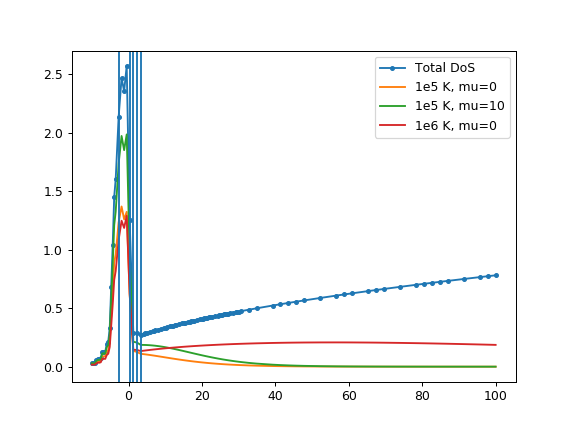

In [11]:
plt.figure()
plt.plot(PAR.E_j,PAR.m_j/PAR.enax_dE_j,'.-', label ='Total DoS')
plt.plot(PAR.E_j,PAR.FermiSolver.fermi(1e5,0)*PAR.m_j/PAR.enax_dE_j, label = '1e5 K, mu=0')
plt.plot(PAR.E_j,PAR.FermiSolver.fermi(1e5,10)*PAR.m_j/PAR.enax_dE_j, label = '1e5 K, mu=10')
plt.plot(PAR.E_j,PAR.FermiSolver.fermi(1e6,0)*PAR.m_j/PAR.enax_dE_j, label = '1e6 K, mu=0')
plt.legend()
for ei in PAR.E_i:
    plt.axvline(ei)

<IPython.core.display.Javascript object>


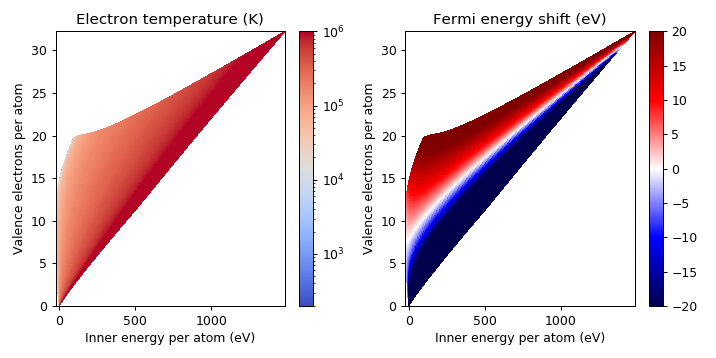

<IPython.core.display.Javascript object>


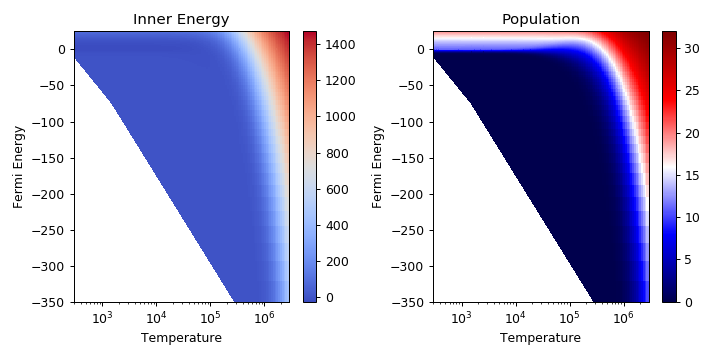

CPU times: user 844 ms, sys: 722 ms, total: 1.57 s
Wall time: 833 ms


In [12]:
%%time

PAR.FermiSolver.plot_lookup_tables()

In [13]:
PAR.m_j[PAR.resonant]

array([1.70820598, 1.12883177, 0.29073542, 0.29073542, 0.24462903])

t:  -15.0
-23.817067157632856 10.000010300233626 -> 352.8786383348662 -0.05000000000001137
Photons impinging per atom this timestep:  [7.55283742e-54 4.05640116e-47 4.05164012e-47 4.05164012e-47
 4.05164012e-47] i.e.  [8.26349827e-56 4.43807566e-49 4.43286665e-49 4.43286665e-49
 4.43286665e-49] /atom
t:  -13.869346816527836
-23.81706639162367 10.000010300233626 -> 357.39611261993167 -0.0546775918086837
Photons impinging per atom this timestep:  [2.86481905e-46 4.96696980e-40 4.96114003e-40 4.96114003e-40
 4.96114003e-40] i.e.  [3.13437533e-48 5.43432145e-42 5.42794313e-42 5.42794313e-42
 5.42794313e-42] /atom
t:  -14.939986216247755
-23.81706711697396 10.000010300233626 -> 352.8786383348662 -0.05000000000001137
Photons impinging per atom this timestep:  [1.96945712e-53 9.96124531e-47 9.94955371e-47 9.94955371e-47
 9.94955371e-47] i.e.  [2.15476709e-55 1.08985178e-48 1.08857262e-48 1.08857262e-48
 1.08857262e-48] /atom
t:  -14.909979324371633
-23.817067099475786 10.000010300233626 -> 35

t:  -10.409931081238772
-23.817066425625434 10.000010300233626 -> 357.39611261993167 -0.0546775918086837
Photons impinging per atom this timestep:  [1.57818755e-26 8.60493850e-22 8.59483881e-22 8.59483881e-22
 8.59483881e-22] i.e.  [1.72668222e-28 9.41459355e-24 9.40354356e-24 9.40354356e-24
 9.40354356e-24] /atom
t:  -9.759931081238772
-23.817066388748046 10.000010300233626 -> 357.39611261993167 -0.0546775918086837
Photons impinging per atom this timestep:  [2.12490478e-23 6.04835423e-19 6.04125522e-19 6.04125522e-19
 6.04125522e-19] i.e.  [2.32484111e-25 6.61745539e-21 6.60968843e-21 6.60968843e-21
 6.60968843e-21] /atom
t:  -9.644375525683216
-23.817066343503896 10.000010300233626 -> 357.39611261993167 -0.0546775918086837
Photons impinging per atom this timestep:  [7.31860884e-23 1.85584261e-18 1.85366439e-18 1.85366439e-18
 1.85366439e-18] i.e.  [8.00723068e-25 2.03046237e-20 2.02807920e-20 2.02807920e-20
 2.02807920e-20] /atom
t:  -9.499931081238772
-23.817066351197674 10.00001030

 1.64292860e-04] /atom
t:  -4.299931081238772
-23.817041201092632 10.000007220960425 -> 437.62282676892016 -0.08550790167683431
Photons impinging per atom this timestep:  [0.00023351 0.02827134 0.02823815 0.02823815 0.02823815] i.e.  [2.55476089e-06 3.09314396e-04 3.08951351e-04 3.08951351e-04
 3.08951351e-04] /atom
t:  -4.299931081238772
-23.816985507079256 10.000034481330985 -> 487.63977017387947 -0.08550790167683431
Photons impinging per atom this timestep:  [0.00023351 0.02827134 0.02823815 0.02823815 0.02823815] i.e.  [2.55476089e-06 3.09314396e-04 3.08951351e-04 3.08951351e-04
 3.08951351e-04] /atom
t:  -5.423690931361914
-23.817066221332567 10.000010362976061 -> 357.39611261993167 -0.0546775918086837
Photons impinging per atom this timestep:  [3.21723195e-07 1.19832591e-04 1.19691942e-04 1.19691942e-04
 1.19691942e-04] i.e.  [3.51994743e-09 1.31107868e-06 1.30953985e-06 1.30953985e-06
 1.30953985e-06] /atom
t:  -5.335570856423486
-23.817066028658328 10.000010437133788 -> 357.396

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 5.588e-08 over maximum of 1.00001.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -6.636e-05 under minimum of -1e-05.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 4.344e-05 over maximum of 1.00001.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -3.653e-05 under minimum of -1e-05.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 3.097e-05 over maximum of 1.00001.Valence occupation in proc_res_inter_Ej

-23.81662491884747 10.000139485441522 -> 597.3996740140926 -0.0821024604174454
Photons impinging per atom this timestep:  [0.00172344 0.1410485  0.14088295 0.14088295 0.14088295] i.e.  [1.88560512e-05 1.54320022e-03 1.54138895e-03 1.54138895e-03
 1.54138895e-03] /atom
t:  -4.597026811201975
-23.817049769241578 10.000015642558562 -> 427.2969439103755 -0.08014764011963393
Photons impinging per atom this timestep:  [4.62695595e-05 7.54001614e-03 7.53116636e-03 7.53116636e-03
 7.53116636e-03] i.e.  [5.06231505e-07 8.24947061e-05 8.23978814e-05 8.23978814e-05
 8.23978814e-05] /atom
t:  -4.5361750508757215
-23.817041353609547 10.000018379670149 -> 437.62282676892016 -0.08014764011963393
Photons impinging per atom this timestep:  [6.49242853e-05 9.95534933e-03 9.94366465e-03 9.94366465e-03
 9.94366465e-03] i.e.  [7.10331349e-07 1.08920671e-04 1.08792830e-04 1.08792830e-04
 1.08792830e-04] /atom
t:  -4.23191624924445
-23.81696955207722 10.000039525930205 -> 487.63977017387947 -0.08210246041744

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 6.212e-06 over maximum of 1.00001.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)


 [0.00222284 0.17268065 0.17247797 0.17247797 0.17247797] i.e.  [2.43198592e-05 1.88928498e-03 1.88706751e-03 1.88706751e-03
 1.88706751e-03] /atom
t:  -3.8561919438862327
-23.81653903002059 10.000170168547772 -> 597.3996740140926 -0.07819281980818005
Photons impinging per atom this timestep:  [0.00222284 0.17268065 0.17247797 0.17247797 0.17247797] i.e.  [2.43198592e-05 1.88928498e-03 1.88706751e-03 1.88706751e-03
 1.88706751e-03] /atom
t:  -4.150125677057504
-23.8169236531627 10.000055321638293 -> 518.8846957111873 -0.0821024604174454
Photons impinging per atom this timestep:  [0.00051078 0.05323843 0.05317594 0.05317594 0.05317594] i.e.  [5.58841733e-06 5.82477354e-04 5.81793695e-04 5.81793695e-04
 5.81793695e-04] /atom
t:  -4.119157600824666
-23.816896946249308 10.000063384764607 -> 518.8846957111873 -0.0821024604174454
Photons impinging per atom this timestep:  [0.00059881 0.06051083 0.06043981 0.06043981 0.06043981] i.e.  [6.55157905e-06 6.62044123e-04 6.61267076e-04 6.61267076e-

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -3.076e-05 under minimum of -1e-05.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 3.445e-05 over maximum of 1.00001.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -1.456e-05 under minimum of -1e-05.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 2.731e-05 over maximum of 1.00001.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)


-23.816637483039003 10.000142643357263 -> 597.3996740140926 -0.0821024604174454
Photons impinging per atom this timestep:  [0.00177431 0.1443532  0.14418377 0.14418377 0.14418377] i.e.  [1.94126187e-05 1.57935668e-03 1.57750297e-03 1.57750297e-03
 1.57750297e-03] /atom
t:  -4.156514244344983
-23.81692693182959 10.000054325291925 -> 518.8846957111873 -0.0821024604174454
Photons impinging per atom this timestep:  [0.00049424 0.05184439 0.05178354 0.05178354 0.05178354] i.e.  [5.40742923e-06 5.67225279e-04 5.66559522e-04 5.66559522e-04
 5.66559522e-04] /atom
t:  -4.128740451755883
-23.816903821853618 10.000061221073922 -> 518.8846957111873 -0.0821024604174454
Photons impinging per atom this timestep:  [0.00057012 0.05816613 0.05809786 0.05809786 0.05809786] i.e.  [6.23765342e-06 6.36390912e-04 6.35643974e-04 6.35643974e-04
 6.35643974e-04] /atom
t:  -3.9898714888103854
-23.816784387123672 10.000101396811425 -> 555.1973462853923 -0.0821024604174454
Photons impinging per atom this timestep:

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -2.347e-05 under minimum of -1e-05.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 2.895e-05 over maximum of 1.00001.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -9.462e-06 under minimum of -1e-05.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 2.255e-05 over maximum of 1.00001.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)


Photons impinging per atom this timestep:  [0.00194473 0.15527975 0.1550975  0.1550975  0.1550975 ] i.e.  [2.12770962e-05 1.69890319e-03 1.69690917e-03 1.69690917e-03
 1.69690917e-03] /atom
t:  -3.858295696423278
-23.816540575805174 10.000168861414723 -> 597.3996740140926 -0.07819281980818005
Photons impinging per atom this timestep:  [0.00220024 0.17128507 0.17108403 0.17108403 0.17108403] i.e.  [2.40726136e-05 1.87401606e-03 1.87181651e-03 1.87181651e-03
 1.87181651e-03] /atom
t:  -3.7315820177417645
-23.816230306097 10.000272043096494 -> 646.4469465596871 -0.07819281980818005
Photons impinging per atom this timestep:  [0.00403961 0.27705053 0.27672535 0.27672535 0.27672535] i.e.  [4.41970998e-05 3.03118738e-03 3.02762965e-03 3.02762965e-03
 3.02762965e-03] /atom
t:  -3.7090551415317177
-23.816248441277022 10.000292390064455 -> 646.4469465596871 -0.07819281980818005
Photons impinging per atom this timestep:  [0.00449283 0.30127005 0.30091645 0.30091645 0.30091645] i.e.  [4.91557193e-

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -1.679e-05 under minimum of -1e-05.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 4.558e-05 over maximum of 1.00001.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 3.525e-05 over maximum of 1.00001.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)


-23.816223744725864 10.000262313342478 -> 646.4469465596871 -0.07819281980818005
Photons impinging per atom this timestep:  [0.00383028 0.26566079 0.26534898 0.26534898 0.26534898] i.e.  [4.19067382e-05 2.90657319e-03 2.90316172e-03 2.90316172e-03
 2.90316172e-03] /atom
t:  -3.7045131370774445
-23.816089247537356 10.000300536725396 -> 646.4469465596871 -0.07819281980818005
Photons impinging per atom this timestep:  [0.00458992 0.30638525 0.30602564 0.30602564 0.30602564] i.e.  [5.02178951e-05 3.35213617e-03 3.34820173e-03 3.34820173e-03
 3.34820173e-03] /atom
t:  -3.685362239864549
-23.816004407353038 10.000326241991786 -> 673.8776633454817 -0.07819281980818005
Photons impinging per atom this timestep:  [0.00502173 0.32885097 0.32846499 0.32846499 0.32846499] i.e.  [5.49423090e-05 3.59793178e-03 3.59370886e-03 3.59370886e-03
 3.59370886e-03] /atom
t:  -3.589607753800073
-23.815338930741735 10.000466190606993 -> 703.4493696606332 -0.07819281980818005
Photons impinging per atom this time

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 6.459e-07 over maximum of 1.00001.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -3.607e-04 under minimum of -1e-05.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 2.852e-04 over maximum of 1.00001.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -3.184e-05 under minimum of -1e-05.valence occupation deviation in proc_nonres_inter()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -2.689e-04 under minimum of -1e-05.Valence occupation in p

 i.e.  [0.00010204 0.00584402 0.00583716 0.00583716 0.00583716] /atom
t:  -3.510081380461072
-23.814965553488065 10.000621201907533 -> 735.3291714557308 -0.07819281980818005
Photons impinging per atom this timestep:  [0.01124211 0.61783191 0.61710675 0.61710675 0.61710675] i.e.  [0.000123   0.00675965 0.00675172 0.00675172 0.00675172] /atom
t:  -3.489469091004467
-23.814759062364942 10.000676841297542 -> 735.3291714557308 -0.07819281980818005
Photons impinging per atom this timestep:  [0.01233471 0.66404825 0.66326885 0.66326885 0.66326885] i.e.  [0.00013495 0.0072653  0.00725677 0.00725677 0.00725677] /atom
t:  -3.3864076437214403
-23.81380238712546 10.000980004827209 -> 806.7477169570385 -0.07329112118739545
Photons impinging per atom this timestep:  [0.01948797 0.94640795 0.94529714 0.94529714 0.94529714] i.e.  [0.00021322 0.01035457 0.01034242 0.01034242 0.01034242] /atom
t:  -3.368085608648902
-23.813881123061712 10.00103999144508 -> 769.6972174114014 -0.07329112118739545
Photons 

Photons impinging per atom this timestep:  [ 1.03410468 18.01477917 17.99363506 17.99363506 17.99363506] i.e.  [0.01131406 0.19709824 0.1968669  0.1968669  0.1968669 ] /atom
t:  -2.211567176448864
-23.659162047419926 10.034533392239906 -> 2490.047256192668 -0.004455490194146705
Photons impinging per atom this timestep:  [ 1.69087547 25.36276382 25.33299532 25.33299532 25.33299532] i.e.  [0.01849973 0.27749195 0.27716625 0.27716625 0.27716625] /atom
t:  -2.1849679246823093
-23.633715051228265 10.036584382124863 -> 2643.215151893212 0.0002645778705243629
Photons impinging per atom this timestep:  [ 1.84101665 26.88999755 26.85843652 26.85843652 26.85843652] i.e.  [0.02014241 0.29420129 0.29385598 0.29385598 0.29385598] /atom
t:  -2.1517188599741153
-23.619280878924638 10.039682839328565 -> 2806.7270309684955 0.006734280779056689
Photons impinging per atom this timestep:  [ 2.0455412  28.90023623 28.86631576 28.86631576 28.86631576] i.e.  [0.0223801  0.31619514 0.31582402 0.31582402 0.315

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 2.903e-04 over maximum of 1.00001.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 3.532e-05 over maximum of 1.00001.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)


Photons impinging per atom this timestep:  [ 3.3379045  40.21058404 40.16338852 40.16338852 40.16338852] i.e.  [0.03651974 0.43994074 0.43942438 0.43942438 0.43942438] /atom
t:  -1.9343764503091574
-23.50812083985746 10.064820563501893 -> 3644.936777305184 0.06427162751367632
Photons impinging per atom this timestep:  [ 3.96317595 45.05530204 45.00242023 45.00242023 45.00242023] i.e.  [0.04336079 0.49294641 0.49236784 0.49236784 0.49236784] /atom
t:  -1.9054054136822665
-23.48425200420682 10.069274561021198 -> 3906.402036707701 0.08674768371884056
Photons impinging per atom this timestep:  [ 4.31301838 47.63233798 47.57643148 47.57643148 47.57643148] i.e.  [0.04718838 0.52114155 0.52052988 0.52052988 0.52052988] /atom
t:  -1.760550230547811
-23.33908014475837 10.092187203686898 -> 5172.8983982095015 0.1868438438035298
Photons impinging per atom this timestep:  [ 6.50134774 62.11753014 62.04462224 62.04462224 62.04462224] i.e.  [0.07113072 0.67962287 0.67882519 0.67882519 0.67882519] /a

-18.653742611101357 10.335547607630614 -> 26416.030175789525 2.468666375536202
Photons impinging per atom this timestep:  [122.30176962 277.6796377  277.35372263 277.35372263 277.35372263] i.e.  [1.33809376 3.03807043 3.03450462 3.03450462 3.03450462] /atom
t:  -0.28049525758357796
-18.371443156551976 10.33243969587253 -> 27279.26764009474 2.549248898886958
Photons impinging per atom this timestep:  [129.34642055 281.31020714 280.98003084 280.98003084 280.98003084] i.e.  [1.41516871 3.0777922  3.07417977 3.07417977 3.07417977] /atom
t:  -0.06543130819746218
-16.9568409790539 10.321472752286883 -> 31551.414441235178 2.84883079070255
Photons impinging per atom this timestep:  [166.4602183  291.97149194 291.62880239 291.62880239 291.62880239] i.e.  [1.82122777 3.19443645 3.19068712 3.19068712 3.19068712] /atom
t:  -0.027197717195486082
-16.750084547383736 10.329249090769983 -> 32130.927323156757 2.91224927196032
Photons impinging per atom this timestep:  [173.25434426 292.48896436 292.145

Photons impinging per atom this timestep:  [20.16563918  1.20441605  1.20300242  1.20300242  1.20300242] i.e.  [0.22063063 0.01317742 0.01316195 0.01316195 0.01316195] /atom
t:  3.9242358316896606
40.25233981757386 9.675002671121185 -> 133279.5939172166 2.1671774448577708
Photons impinging per atom this timestep:  [4.08266797 0.13252067 0.13236513 0.13236513 0.13236513] i.e.  [0.04466814 0.0014499  0.0014482  0.0014482  0.0014482 ] /atom
t:  4.032641528788929
43.04207696568558 9.663935648215634 -> 137796.9205431593 1.7898973931753233
Photons impinging per atom this timestep:  [2.9561004  0.08609516 0.08599411 0.08599411 0.08599411] i.e.  [0.03234246 0.00094196 0.00094085 0.00094085 0.00094085] /atom
t:  4.168148650163015
44.58698708795512 9.648999396614737 -> 140027.7799975116 1.644948858872766
Photons impinging per atom this timestep:  [1.9420524  0.04939358 0.04933561 0.04933561 0.04933561] i.e.  [0.02124784 0.00054041 0.00053978 0.00053978 0.00053978] /atom
t:  4.168148650163015
43.

Photons impinging per atom this timestep:  [1.43735287e-03 6.18342073e-06 6.17616320e-06 6.17616320e-06
 6.17616320e-06] i.e.  [1.57259614e-05 6.76523056e-08 6.75729015e-08 6.75729015e-08
 6.75729015e-08] /atom
t:  6.394280573515965
89.12972682016938 9.465522947047912 -> 200503.2245644078 -3.0147314950266377
Photons impinging per atom this timestep:  [1.40992598e-04 3.87087438e-07 3.86633110e-07 3.86633110e-07
 3.86633110e-07] i.e.  [1.54258860e-06 4.23509232e-09 4.23012155e-09 4.23012155e-09
 4.23012155e-09] /atom
t:  6.47412506815241
92.47015390342563 9.460512709320628 -> 204884.99064075106 -3.397162090216966
Photons impinging per atom this timestep:  [9.13607737e-05 2.31577579e-07 2.31305775e-07 2.31305775e-07
 2.31305775e-07] i.e.  [9.99570829e-07 2.53367155e-09 2.53069775e-09 2.53069775e-09
 2.53069775e-09] /atom
t:  6.573930686447967
94.53590256253358 9.455267717093594 -> 207683.82739176613 -3.6573009273388664
Photons impinging per atom this timestep:  [5.26405743e-05 1.20757004e

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -2.642e-03 under minimum of -1e-05.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -4.776e-04 under minimum of -1e-05.valence occupation deviation in proc_nonres_inter()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -2.312e-03 under minimum of -1e-05.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -3.840e-04 under minimum of -1e-05.valence occupation deviation in proc_nonres_inter()
  warnings.warn(string)


Photons impinging per atom this timestep:  [5.26405743e-05 1.20757004e-07 1.20615271e-07 1.20615271e-07
 1.20615271e-07] i.e.  [5.75936262e-07 1.32119261e-09 1.31964191e-09 1.31964191e-09
 1.31964191e-09] /atom
t:  6.741836816816473
95.70679612174649 9.447415147643381 -> 209401.7135447289 -3.837896195940175
Photons impinging per atom this timestep:  [2.03584046e-05 3.94834185e-08 3.94370765e-08 3.94370765e-08
 3.94370765e-08] i.e.  [2.22739657e-07 4.31984886e-10 4.31477861e-10 4.31477861e-10
 4.31477861e-10] /atom
t:  6.825789882000726
97.49394333408878 9.443633090175647 -> 211789.1986394935 -4.057443407348899
Photons impinging per atom this timestep:  [1.25274843e-05 2.23395550e-08 2.23133349e-08 2.23133349e-08
 2.23133349e-08] i.e.  [1.37062191e-07 2.44415263e-10 2.44128391e-10 2.44128391e-10
 2.44128391e-10] /atom
t:  7.245555207921992
106.18664535731973 9.424993422968829 -> 223694.10821696065 -5.212174329463949
Photons impinging per atom this timestep:  [9.94374799e-07 1.16535702e-

Photons impinging per atom this timestep:  [1.49632644e-26 9.97811097e-32 9.96639957e-32 9.96639957e-32
 9.96639957e-32] i.e.  [1.63711865e-28 1.09169704e-33 1.09041571e-33 1.09041571e-33
 1.09041571e-33] /atom
t:  12.559042785159795
219.05069368384147 9.355720713711957 -> 414633.3825166881 -27.95312880319618
Photons impinging per atom this timestep:  [2.84735571e-27 1.64335836e-32 1.64142954e-32 1.64142954e-32
 1.64142954e-32] i.e.  [3.11526883e-29 1.79798508e-34 1.79587477e-34 1.79587477e-34
 1.79587477e-34] /atom
t:  12.559042785159795
218.94759809464708 9.356350427545285 -> 414365.85777650576 -27.914693924314932
Photons impinging per atom this timestep:  [2.84735571e-27 1.64335836e-32 1.64142954e-32 1.64142954e-32
 1.64142954e-32] i.e.  [3.11526883e-29 1.79798508e-34 1.79587477e-34 1.79587477e-34
 1.79587477e-34] /atom
t:  12.819042785159795
224.29642315943 9.357439049810845 -> 426585.1463521901 -29.54688619885009
Photons impinging per atom this timestep:  [1.36318614e-28 6.0663735

Photons impinging per atom this timestep:  [3.72888887e-61 9.15423639e-69 9.14349198e-69 9.14349198e-69
 9.14349198e-69] i.e.  [4.07974712e-63 1.00155759e-70 1.00038205e-70 1.00038205e-70
 1.00038205e-70] /atom
t:  18.149042785159796
327.13389906904774 9.415162917710195 -> 818689.7926909301 -85.80361393626929
Photons impinging per atom this timestep:  [4.04616626e-62 8.72224183e-70 8.71200446e-70 8.71200446e-70
 8.71200446e-70] i.e.  [4.42687774e-64 9.54293417e-72 9.53173355e-72 9.53173355e-72
 9.53173355e-72] /atom
t:  18.799042785159795
338.72035997011216 9.4243767308629 -> 900387.7086626876 -98.0192047026707
Photons impinging per atom this timestep:  [4.72358235e-67 5.31574914e-75 5.30951000e-75 5.30951000e-75
 5.30951000e-75] i.e.  [5.16803321e-69 5.81591810e-77 5.80909190e-77 5.80909190e-77
 5.80909190e-77] /atom
t:  18.91459834071535
340.71377475092356 9.425964027711258 -> 915982.2971830751 -100.36179507640253
Photons impinging per atom this timestep:  [5.99962974e-68 6.01495379e

<IPython.core.display.Javascript object>


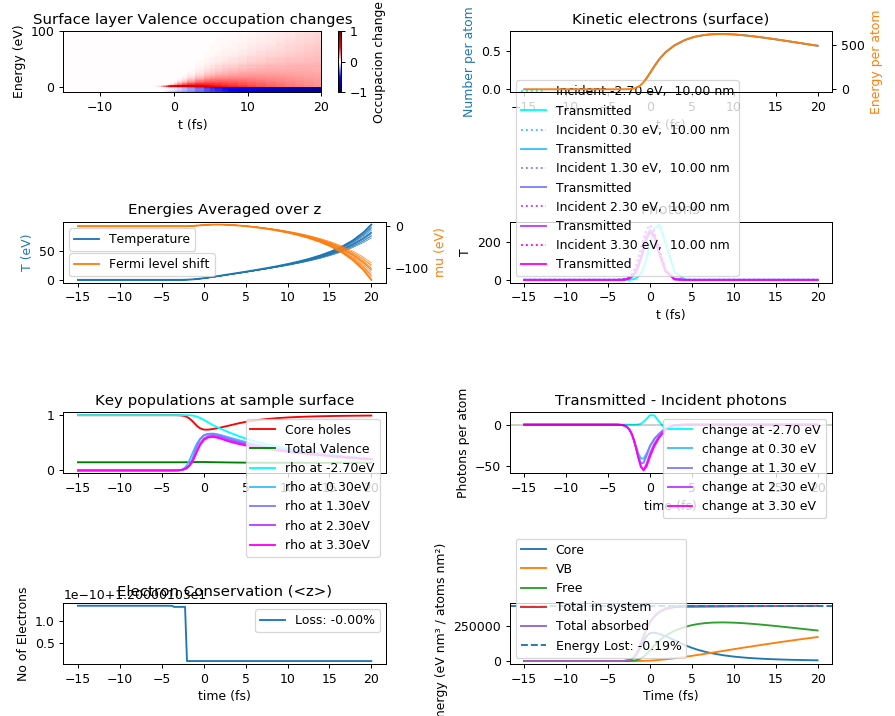

Done
Transmission:  [101.19798194  86.48294628  85.46528908  83.03135246  82.18645979]  %
CPU times: user 1min 31s, sys: 4min 52s, total: 6min 23s
Wall time: 45.7 s


In [14]:
%%time
sim_options = dict(t_span=[-15, 20],
                   method='RK45',
                   rtol=1e-3, atol=1e-8, 
                   plot = True,
                   return_full_solution = True)

incident, transmitted, sol = sim.run(**sim_options)

print('Transmission: ', 100 * transmitted/incident, ' %')


<IPython.core.display.Javascript object>


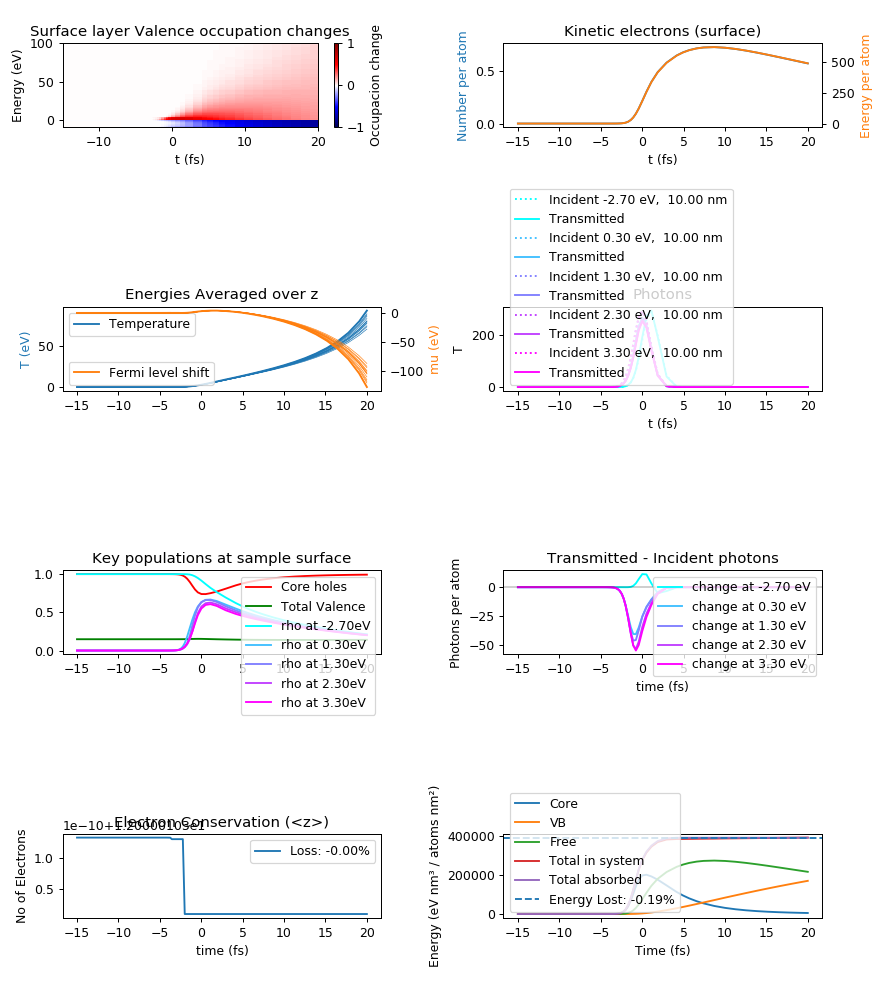

Done


In [15]:

sim.plot_results(sol, sol.photon_densities)

In [16]:
self = sim
inner_energies = np.zeros((len(sol.t),self.par.Nsteps_z))
for it, t in enumerate(sol.t):
    for iz in range(self.par.Nsteps_z):
        U = np.sum(sol.rho_j[iz, :, it] * self.par.E_j)
        R = sol.R_VB[iz, it]
        T, mu_chem = self.par.FermiSolver.solve(U, R)
        if np.isnan(T):
            T, mu_chem = self.par.FermiSolver.save_lookup_Tmu_from_UR(U, R)
        # if self.DEBUG and (iz==0):
        #    print(U,R,'->',T, mu_chem)
        sol.temperatures[it, iz], sol.chemical_potentials[it, iz] = (T, mu_chem)
        inner_energies[it,iz] = U # This is needed later to check the energy conservation

In [17]:

## Integrat energy for each timestepsol.chemical_potentials+
absorbed_energy_dt = np.sum((sol.photon_densities[0]-sol.photon_densities[-1]).T*(self.par.E_i+self.par.E_f),1)
absorbed_energy = np.array([np.trapz(absorbed_energy_dt[:i+1],sol.t[:i+1]) for i in range(len(absorbed_energy_dt))])

factor = self.par.atomic_density * self.par.zstepsize # From energy per atom to energy per nm²
total_free = np.sum(sol.E_free[:,:],0) * factor#*1.01
#total_free_simple = np.sum(sol.R_free[:,:]*(self.par.E_f),0) * factor
total_inner = (np.sum(inner_energies[:,:],1)-np.sum(inner_energies[0,:])) * factor#*0.9
#total_inner = total_inner - total_inner[0]
total_core = np.sum((self.par.M_core- sol.core[:,:])*self.par.E_f,0) * factor#*1.13
#total_core = np.sum(self.par.M_core * (self.par.M_core/sol.core[:,:])*self.par.E_f,0) * factor

total_energies = total_free + total_inner + total_core
#total_energies_simple = total_free_simple + total_inner + total_core


<IPython.core.display.Javascript object>


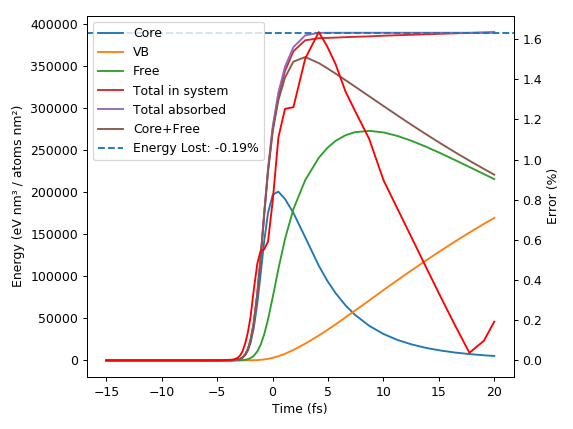

Done


In [18]:

plt.figure()
ax1 = plt.gca()
plt.plot(sol.t, total_core, label = 'Core')
plt.plot(sol.t, total_inner, label = 'VB')
plt.plot(sol.t, total_free, label = 'Free')
#plt.plot(sol.t, total_free_simple, label = 'Free simple')
plt.plot(sol.t, total_energies, label = 'Total in system')
#plt.plot(sol.t, total_energies_simple, label = 'Total in system simple')
plt.plot(sol.t, absorbed_energy, label = 'Total absorbed')
plt.plot(sol.t, total_free+total_core, label = 'Core+Free')



plt.axhline(absorbed_energy[-1], ls='--', label=f'Energy Lost: {100*(absorbed_energy[-1]-total_energies[-1])/absorbed_energy[-1]:.2f}%')
plt.legend()

plt.xlabel('Time (fs)')
plt.ylabel('Energy (eV nm³ / atoms nm²)')

ax2 = ax1.twinx()
err = np.abs(absorbed_energy-total_energies)/np.max(absorbed_energy)
#err[absorbed_energy< 1e-2*np.max(absorbed_energy)]=0
ax2.plot(sol.t, 100*err,  color='red')
ax2.set_ylabel('Error (%)')

plt.tight_layout()
plt.show()
#plt.pause(20)

print('Done')

In [19]:
### calculate rates

it = 50
t = sol.t[it]

all_changes = np.zeros((len(sol.t), PAR.Nsteps_z, PAR.states_per_voxel))

for it, t in enumerate(sol.t):
    photons = np.zeros((PAR.Nsteps_z, PAR.N_j))
    photons[:,PAR.resonant] = sol.photon_densities[:-1,:,it]
    states = sol.y[:,it].reshape(PAR.Nsteps_z, PAR.states_per_voxel)
    rj_z = np.zeros((PAR.Nsteps_z, PAR.N_j))
    for iz in range(PAR.Nsteps_z):
        rj_z[iz,:] = PAR.FermiSolver.fermi(sol.temperatures[it,iz], sol.chemical_potentials[it,iz]) * PAR.m_j
    res_inter, nonres_inter, ch_decay, el_therm, el_scatt, en_free = sim.calc_processes(photons , states, rj_z)

    all_changes[it,:, 0] = sim.rate_core(res_inter, ch_decay)
    all_changes[it,:, 1] = sim.rate_free(nonres_inter, ch_decay, el_scatt)
    all_changes[it,:, 2] = sim.rate_E_free(nonres_inter, ch_decay, el_scatt)
    all_changes[it,:, 3:] = sim.rate_j(res_inter,nonres_inter,ch_decay,el_therm,el_scatt)
    
core_changes = all_changes[:,:,0]
free_changes = all_changes[:,:,1]
efree_changes = all_changes[:,:,2]
j_changes = all_changes[:,:,3:]


IndexError: index 50 is out of bounds for axis 0 with size 46

In [20]:
def plot_conservations(self, sol):
    """
    Plot Energy and electron conservations. Call after plot_results()
    """
    PAR = self.par
    all_changes = np.zeros((len(sol.t), PAR.Nsteps_z, PAR.states_per_voxel))

    for it, t in enumerate(sol.t):
        photons = np.zeros((PAR.Nsteps_z, PAR.N_j))
        photons[:,PAR.resonant] = sol.photon_densities[:-1,:,it]
        states = sol.y[:,it].reshape(PAR.Nsteps_z, PAR.states_per_voxel)
        rj_z = np.zeros((PAR.Nsteps_z, PAR.N_j))
        for iz in range(PAR.Nsteps_z):
            rj_z[iz,:] = PAR.FermiSolver.fermi(sol.temperatures[it,iz], sol.chemical_potentials[it,iz]) * PAR.m_j
        res_inter, nonres_inter, ch_decay, el_therm, el_scatt, en_free = sim.calc_processes(photons , states, rj_z)

        all_changes[it,:, 0] = sim.rate_core(res_inter, ch_decay)
        all_changes[it,:, 1] = sim.rate_free(nonres_inter, ch_decay, el_scatt)
        all_changes[it,:, 2] = sim.rate_E_free(nonres_inter, ch_decay, el_scatt)
        all_changes[it,:, 3:] = sim.rate_j(res_inter,nonres_inter,ch_decay,el_therm,el_scatt)

    core_changes = all_changes[:,:,0]
    free_changes = all_changes[:,:,1]
    efree_changes = all_changes[:,:,2]
    j_changes = all_changes[:,:,3:]


In [16]:
U_changes = np.sum(j_changes*PAR.E_j,2) # this is just the derivative at each point
U_changes_actual = np.gradient(sol.inner_energies,sol.t, axis = 0)# This is the actual change, which is different due to RK45

<IPython.core.display.Javascript object>


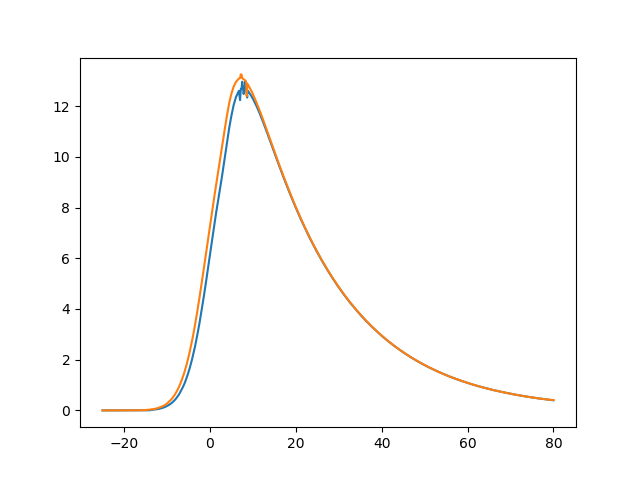

In [17]:
plt.figure()
#plt.plot(sol.t,core_changes[:,0])
#plt.plot(sol.t,free_changes[:,0])
plt.plot(sol.t,U_changes[:,0])
plt.plot(sol.t[:],U_changes_actual[:,0])

#plt.plot(sol.t,j_changes[:,0][:,PAR.resonant])

<IPython.core.display.Javascript object>


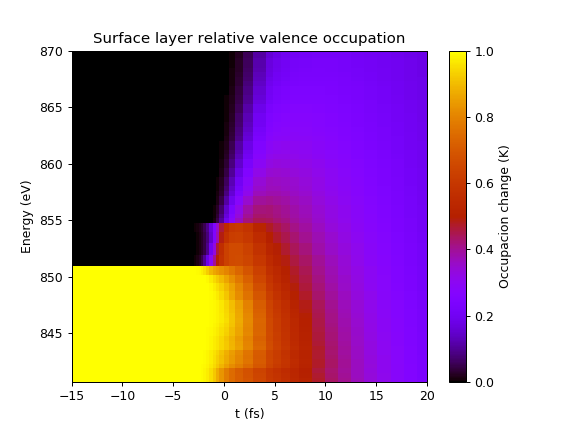

(840.7, 870)

In [21]:
plt.figure()
plt.pcolormesh(sol.t, PAR.E_j +PAR.E_f,
               (sol.rho_j[0])/np.outer(PAR.m_j,np.ones(sol.t.shape)),
               cmap = plt.cm.gnuplot, vmin = 0, vmax = 1, shading = 'nearest')#
plt.colorbar(label = 'Occupacion change (K)')
plt.xlabel('t (fs)')
plt.ylabel('Energy (eV)')
plt.title('Surface layer relative valence occupation')
plt.ylim(None, 870)

<IPython.core.display.Javascript object>


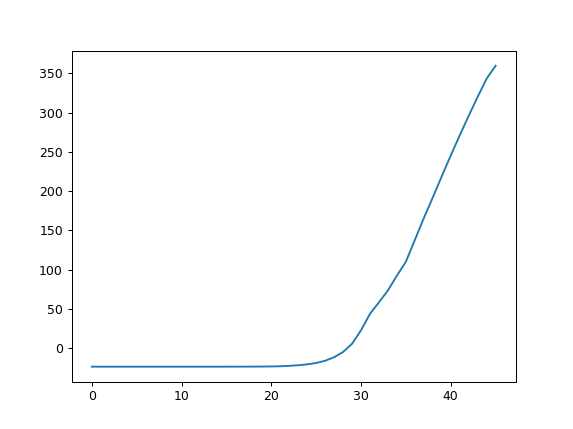

In [28]:
plt.figure()
plt.plot(sol.inner_energies[:,0])

<IPython.core.display.Javascript object>


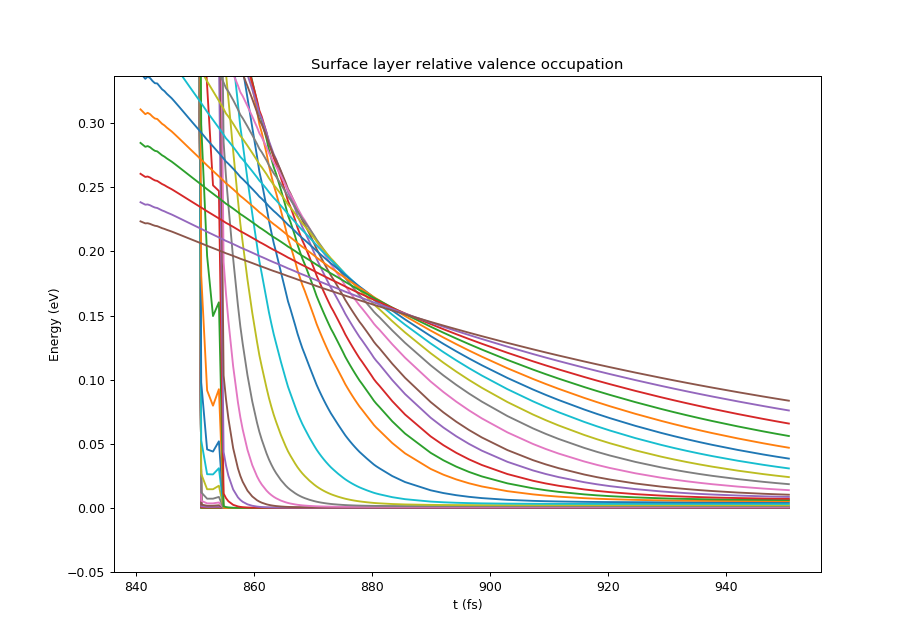

Text(0.5, 1.0, 'Surface layer relative valence occupation')

In [25]:
plt.figure()
plt.plot(PAR.E_j +PAR.E_f,
               (sol.rho_j[0])/np.outer(PAR.m_j,np.ones(sol.t.shape)))#
plt.xlabel('t (fs)')
plt.ylabel('Energy (eV)')
plt.title('Surface layer relative valence occupation')


<IPython.core.display.Javascript object>


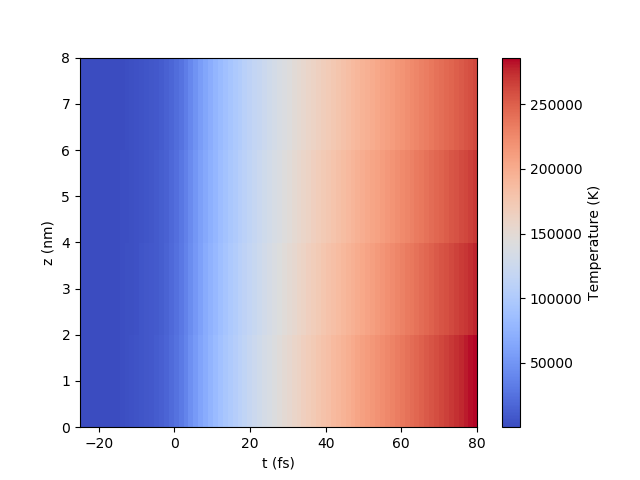

Text(0, 0.5, 'z (nm)')

In [14]:
plt.figure()
plt.pcolormesh(sol.t, PAR.zaxis, sol.temperatures.T, cmap = plt.cm.coolwarm)
plt.colorbar(label = 'Temperature (K)')
plt.xlabel('t (fs)')
plt.ylabel('z (nm)')

<IPython.core.display.Javascript object>


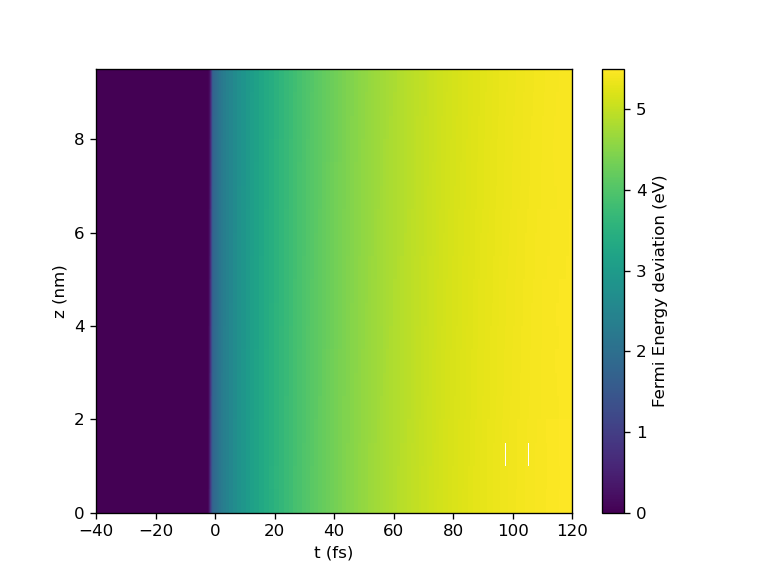

/tmp/ipykernel_186854/203480434.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(sol.t, PAR.zaxis, sol.fermi_energies.T)


Text(0, 0.5, 'z (nm)')

In [35]:
plt.figure()
plt.pcolormesh(sol.t, PAR.zaxis, sol.fermi_energies.T)
plt.colorbar(label = 'Fermi Energy deviation (eV)')
plt.xlabel('t (fs)')
plt.ylabel('z (nm)')

<IPython.core.display.Javascript object>


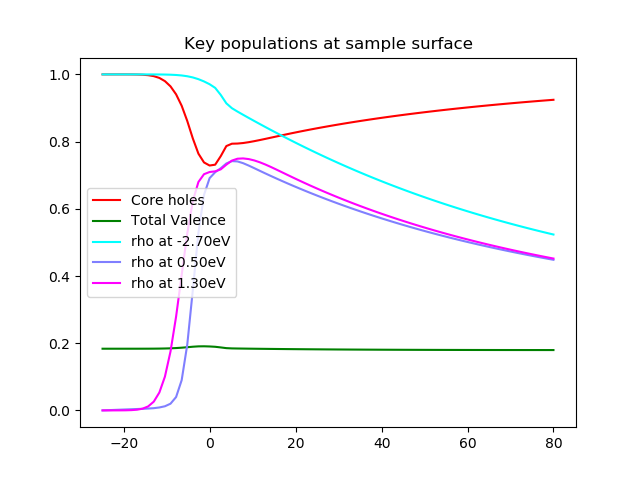

In [15]:
plt.figure()
plt.title('Key populations at sample surface')
plt.plot(sol.t,sol.core[0]/PAR.M_core, c='red', label = 'Core holes')
plt.plot(sol.t,(sol.R_VB[0])/PAR.M_VB, c='green',label = 'Total Valence')
cols = plt.cm.cool(np.linspace(0,1,PAR.N_photens))
for iE,E in enumerate(PAR.E_i):
    plt.plot(sol.t,sol.rho_j[0,PAR.resonant,:][iE].T/PAR.m_j[PAR.resonant][iE],c = cols[iE], label = f'rho at {E:.2f}eV')
plt.legend()


<IPython.core.display.Javascript object>


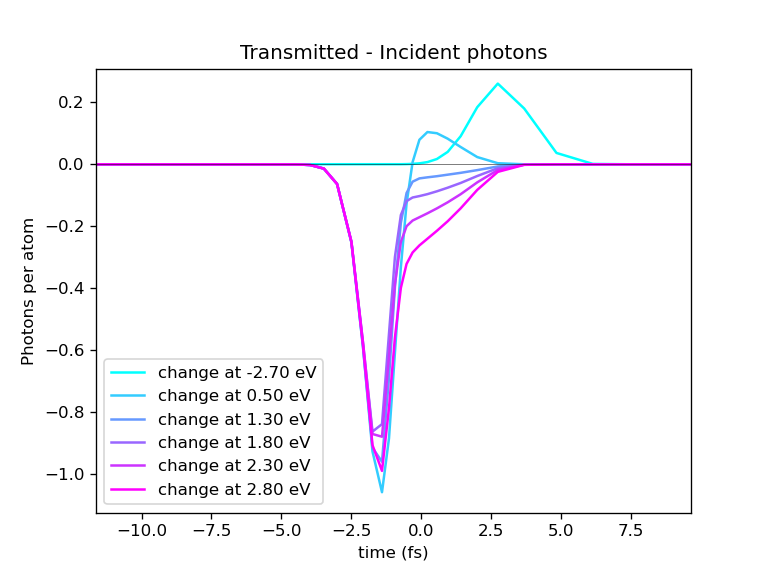

Text(0, 0.5, 'Photons per atom')

In [13]:
T = (sol.photon_densities[-1]-sol.photon_densities[0])#/np.max(sol.photon_densities[0],1)

plt.figure()
for iE,E in enumerate(PAR.E_i):
    plt.plot(sol.t,T[iE],c = cols[iE], label = f'change at {E:.2f} eV')
plt.axhline(c='k', lw = 0.3)
plt.legend()

plt.title('Transmitted - Incident photons')
plt.xlabel('time (fs)')
plt.ylabel('Photons per atom')

In [24]:
PAR.M_core

2

<IPython.core.display.Javascript object>


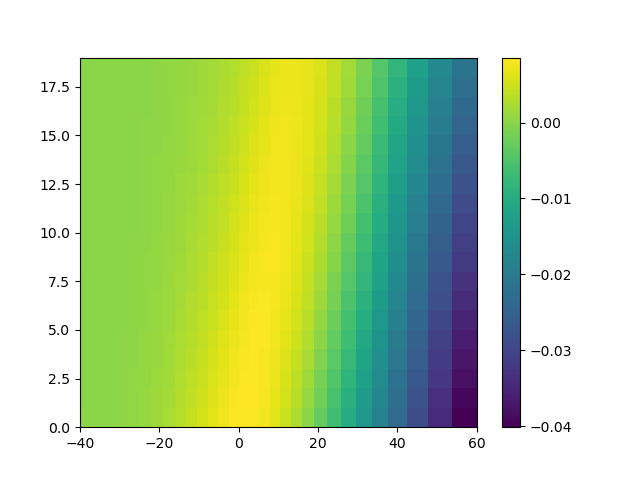

/tmp/ipykernel_121456/52012410.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(sol.t, PAR.zaxis, (sol.R_VB-PAR.R_VB_0)/PAR.M_VB)


In [34]:
plt.figure()
plt.pcolormesh(sol.t, PAR.zaxis, (sol.R_VB-PAR.R_VB_0)/PAR.M_VB)
plt.colorbar()

In [21]:
sol.t.shape

(40,)

In [77]:
def make_valence_energy_axis(self, N_j: int, min=-6, finemax=10, max=50):
        """
        Creates an energy axis for the valence band, namely
            self.E_j
        and its edgepoints
            self.enax_j_edges
        Energies are relative to the fermi-level. 3/4 of all points fall into the range (min, finemax)
        Makes sure that the energies E_i correspond to a point in E_j and
        drops the closest points to keep the number N_j.
        :param N_j:
        :param min:
        :param finemax:
        :param max:
        :return:
        """
        N_j_fine = int(N_j * 3 / 4)
        N_j_coarse = int(N_j - N_j_fine)

        def fill_biggest_gap(pointlist):
            """
            This function takes a list of points and appends a point in the middle of the biggest gap
            """
            pointlist = np.array(np.sort(pointlist))
            gaps = pointlist[1:]-pointlist[:-1]
            biggest_gap_index = np.argsort(gaps)[-1]
            biggest_gap = gaps[biggest_gap_index]
            list_before = pointlist[:biggest_gap_index+1]
            new_value = pointlist[biggest_gap_index] + 0.5*biggest_gap
            list_after = pointlist[biggest_gap_index+1:]
            return np.concatenate((list_before, [new_value,], list_after))
        
        # The energies E_i and 0 must be in the axis
        enax_j_fine = [min, 0, finemax]+list(self.E_i[self.E_i<=finemax])
        # Fill up the gaps
        while len(enax_j_fine)<N_j_fine:
            enax_j_fine = fill_biggest_gap(enax_j_fine)
        
        dE = np.mean(enax_j_fine[1:]-enax_j_fine[:-1])
        #The same for the coarse part
        enax_j_coarse = [finemax+dE, max]+list(self.E_i[self.E_i>finemax])
        while len(enax_j_coarse)<N_j_coarse:
            enax_j_coarse = fill_biggest_gap(enax_j_coarse)
            
        enax_j = np.concatenate((enax_j_fine, enax_j_coarse))

        if not len(enax_j) == N_j:
            warnings.warn(
                'Energy Axis turned out longer or shorter than planned. What went wrong?')
            self.N_j = len(enax_j)
            
        def edgepoints(middles):
            """ Opposite of midpoints """
            edges = np.empty(middles.shape[0] + 1)
            edges[1:-1] = (middles[1:] + middles[:-1]) / 2
            edges[0] = middles[0] - (middles[1] - middles[0]) / 2
            edges[-1] = middles[-1] + (middles[-1] - middles[-2]) / 2
            return edges

        return enax_j, edgepoints(enax_j)

In [55]:
sim.plot_derivatives?

<IPython.core.display.Javascript object>


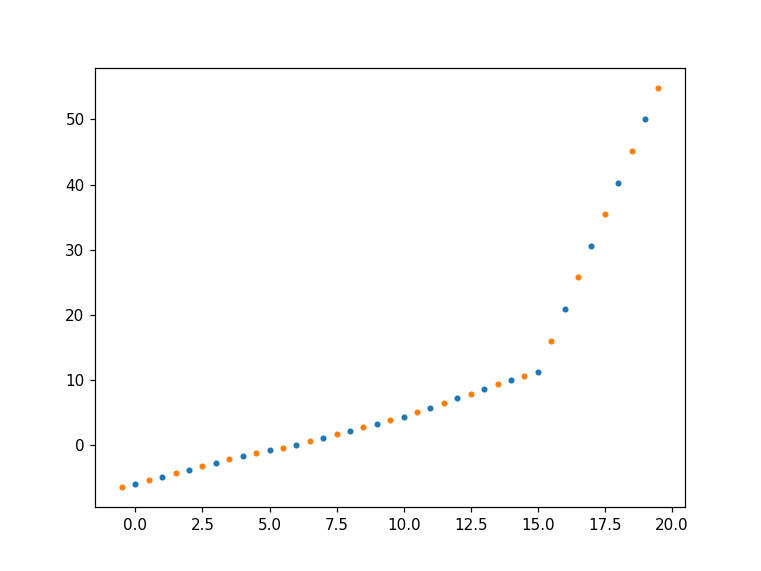

In [82]:
enax, enax_edges = make_valence_energy_axis(PAR, 20, min=-6, finemax=10, max=50)
plt.figure()
plt.plot(np.arange(len(enax)),enax,'.')
plt.plot(np.arange(len(enax_edges))-0.5,enax_edges,'.')